In [1]:
import hist
import math
from time import process_time
import os
import uproot
import awkward as ak
from scipy.stats import moyal

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
import numpy as np
import random

from matplotlib import colors
POPTS={'norm':colors.LogNorm(vmin=1,vmax=200)}

In [2]:
SimParticle_attrs = ['pdgID','trkID','mass','e','kine','vx','vy','vz','endx','endy','endz','px','py','pz']
RecoilSimHit_attrs = ['x', 'y', 'z', 'px', 'py', 'pz', 'pdgid', 'edep', 'pathLength', 'layer']
EcalSimHit_attrs = ['edep', 't', 'x', 'y', 'z', 'layer']
EcalRecHit_attrs = ['amp', 'e', 't', 'x', 'y', 'z', 'layer']

branches = {
    "Sim_Particle": SimParticle_attrs,
    "Recoil_SimHit": RecoilSimHit_attrs,
    "Ecal_SimHit": EcalSimHit_attrs,
    "Ecal_RecHit": EcalRecHit_attrs,
    "n": ["Sim_Particle", "Recoil_SimHit", "Ecal_SimHit", "Ecal_RecHit"]
}

def getData(fnames="", treeName="Events", chunks=False):
    branchlist = []
    for collection, attrs in branches.items():
        branchlist += [collection+"_"+attr for attr in attrs]
    if chunks: ldmx_dict = uproot.iterate(fnames+":"+treeName, branchlist)
    else: ldmx_dict = uproot.lazy(fnames+":"+treeName, branchlist)
    return ldmx_dict

In [3]:
def repackage(ldmx_dict):
    """
    Repackages ldmx_dict into new dictionary of dictionaries of form
    ldmx_events={Sim_particle: {pdgID:___, trkID:___,...}, Ecal_RecHit: {amp:___, e:___, ...}, ...}
    """
    evt_dict={}
    for collection in branches:    
        coll_dict={}
        for attr in branches[collection]:
            bname = "{}_{}".format(collection, attr)
            coll_dict[attr] = ldmx_dict[bname]
        evt_dict[collection] = ak.zip(coll_dict)        
    ldmx_events = ak.zip(evt_dict, depth_limit=1)
    return ldmx_events

def get_vector(arr):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)
    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    return part 

def add_angle(arr):
    part=get_vector(arr)
    arr["theta"] = part.theta*(180/np.pi)
    return 

def add_angle_rTracker(arr):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)
    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    },
                    with_name="ThreeVector")
    arr["theta"] = part.theta*(180/np.pi)

In [4]:
def ProcessChunk(chunk,histsAdd):
    ldmx_events = repackage(chunk)
    sim_particle = ldmx_events['Sim_Particle']
    recoil_simhit = ldmx_events['Recoil_SimHit']
    ecal_simhit = ldmx_events['Ecal_SimHit']
    ecal_rechit = ldmx_events['Ecal_RecHit']

    #Determines Kinetic Energy
    parKine=0
    if ak.all(sim_particle.kine==100):
        parKine=100
    elif ak.all(sim_particle.kine==500):
        parKine=500
    elif ak.all(sim_particle.kine==1000):
        parKine=1000
    elif (ak.all(sim_particle.kine==2000)):
        parKine=2000
        return
    
    #Determines if data file is one for protons or pions
    par=""
    ID=0
    restMass=0
    if ak.all(sim_particle.pdgID==2212):
        par="Proton"
        ID=2212
        restMass=938.27208816
    elif ak.all(sim_particle.pdgID==211):
        par="Pion"
        ID=211
        restMass=139.57039
    
    #Removes empty events. There are a lot of empty events. 
    recoilEmptyMask=getattr(ldmx_events['n'], "Recoil_SimHit")!=0
    recoil_simhit=recoil_simhit[recoilEmptyMask]
    ecalEmptyMask=getattr(ldmx_events['n'], "Ecal_SimHit")!=0
    ecal_simhit=ecal_simhit[ecalEmptyMask]
    ecalRecEmptyMask=getattr(ldmx_events['n'], "Ecal_RecHit")!=0
    ecal_rechit=ecal_rechit[ecalRecEmptyMask]
    
    #pdgID Mask
    recoilIDMask=recoil_simhit.pdgid==ID
    
    #MIP Masks
    recoilMIPMask=recoil_simhit.edep>=.13
    ecalSimMIPMask=ecal_simhit.edep>=.13
    ecalRecMIPMask=ecal_rechit.e>=.13
    
    #dE/dz for variious data sets
    recoilSiWidth=0.32
    ecalSiWidth=0.5
    ecalRecWidths=[2.5,1.5,1.25,3,2.75,4.5,4,5,4,5,4,5,4,5,4,5,4,5,4,5,4,5,4,5,4,8.5,7,8.5,7,8.5,7,8.5,7,8.5,7]
    
    #NEW ATTRIBUTES ADDED TO SIM_PARTICLES
    add_angle(sim_particle)
    
    #NEW ATTRIBUTES ADDED TO RECOIL_SIMHITS
    recoil_simhit["dedz"]=recoil_simhit.edep/recoilSiWidth 
    add_angle_rTracker(recoil_simhit)
    
    #NEW ATTRIBUTES ADDED TO ECAL_SIMHITS
    ecal_simhit["dedz"]=ecal_simhit.edep/ecalSiWidth
    
    #NEW ATTRIBUTES ADDED TO ECAL_RECHITS
    widthMap=[[ecalRecWidths[hit] for hit in evt] for evt in ecal_rechit.layer]
    widthMap=ak.Array(widthMap)
    
    ecal_rechit["dedz"]=ecal_rechit.e/widthMap
    
    #Range of iteration for kinetic energy 2d plots
    kineRange=np.linspace(100,1981,100)
    
    #---------------Recoil Tracker
    #'''
    #Preparing Masked Array to use in Kine Loop
    twoDMask= recoilIDMask #& recoilMIPMask 
    emptiesIncluded=recoil_simhit[twoDMask]
    
    #Apply the emptyMask with ak.mask, so that the 1D data alignment is preserved. If you wished to preserve the 
    #2d alignment, you would apply the 2d mask with ak.mask as well. 
    emptiesMask=ak.num(emptiesIncluded)>0 
    prepared=ak.mask(emptiesIncluded, emptiesMask)
    noEmpties=ak.flatten(prepared, axis=0)
        
    #Fills Energy Average
    edepSum=ak.flatten(ak.sum(noEmpties.edep, axis=1), axis=None)
    edepAvg=ak.flatten(ak.mean(noEmpties.edep, axis=1), axis=None)
    deds=ak.flatten(noEmpties.dedz, axis=None)
    
    mostProb=ak.Array([moyal.fit(np.array(s))[0] for s in noEmpties.edep])
    
    histsAdd["recoil_dedz"].fill(particle=par, var=deds, kine=str(parKine))
    histsAdd["recoil_avgEdep"].fill(particle=par, var=edepAvg, kine=str(parKine))
    histsAdd["recoil_mostProbable"].fill(particle=par, var=mostProb, kine=str(parKine))
    histsAdd["recoil_mostProbabledEdz"].fill(particle=par, var=mostProb/recoilSiWidth, kine=str(parKine))
    
    print("Recoil Done")

In [5]:
hists={}
hists["recoil_dedz"]= hist.Hist(
    hist.axis.StrCategory([], name="particle", growth=True),
    hist.axis.Regular(100, 0, 2.5, name='var', label=r'dE/dz [MeV/mm]'),
    hist.axis.StrCategory([], name='kine', growth=True)
)

hists["recoil_avgEdep"]= hist.Hist(
    hist.axis.StrCategory([], name="particle", growth=True),
    hist.axis.Regular(80, 0, 0.8, name='var', label=r'Average Energy Deposited by Recoil SimHits [MeV]'),
    hist.axis.StrCategory([], name='kine', growth=True)
)

hists["recoil_mostProbable"]= hist.Hist(
    hist.axis.StrCategory([], name="particle", growth=True),
    hist.axis.Regular(80, 0, 0.5, name='var', label=r"Most Probable dE in Recoil Tracker [MeV/mm]"),
    hist.axis.StrCategory([], name='kine', growth=True)
)

hists["recoil_mostProbabledEdz"]= hist.Hist(
    hist.axis.StrCategory([], name="particle", growth=True),
    hist.axis.Regular(80, 0, 0.5, name='var', label=r"Most Probable dE/dx in Recoil Tracker [MeV/mm]"),
    hist.axis.StrCategory([], name='kine', growth=True)
)
    
ldmx_dict_all = getData(chunks=True, fnames="/Users/cmantill/LDMX/ldmxsw/ldmx-helpers/data/Sep30_ntuple/*.root")

start=process_time()
nchunk = 0
for chunk in ldmx_dict_all:
    nchunk += 1
    print('process',nchunk)
    ProcessChunk(chunk,hists)
    #if nchunk==2: break
    
stop=process_time()
print("Elapsed time during the whole program in seconds:", stop-start) 

process 1


/Users/cmantill/miniconda3/envs/darkquest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1797: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


Recoil Done
process 2
process 3


/Users/cmantill/miniconda3/envs/darkquest/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:5681: RuntimeWarning: overflow encountered in exp
  return np.exp(-0.5 * (x + np.exp(-x))) / np.sqrt(2*np.pi)


Recoil Done
process 4
Recoil Done
process 5
process 6
Recoil Done
process 7
Recoil Done
process 8
Recoil Done
Elapsed time during the whole program in seconds: 439.388691


In [6]:
#histsAdd["recoil_dedz"].project("kine")
print(hists["recoil_dedz"][{"kine":"1000"}].project("var"))
#histsAdd["recoil_dedz"][:, :, 0:1][{"kine":sum,"particle":"Proton"}]
#print(histsAdd["recoil_dedz"][:, :, 500:1000])

                     ┌───────────────────────────────────────────────────────┐
[ -inf,     0) 0     │                                                       │
[    0, 0.025) 1038  │▉                                                      │
[0.025,  0.05) 881   │▊                                                      │
[ 0.05, 0.075) 847   │▊                                                      │
[0.075,   0.1) 861   │▊                                                      │
[  0.1, 0.125) 836   │▊                                                      │
[0.125,  0.15) 802   │▋                                                      │
[ 0.15, 0.175) 767   │▋                                                      │
[0.175,   0.2) 996   │▉                                                      │
[  0.2, 0.225) 5245  │████▍                                                  │
[0.225,  0.25) 23969 │███████████████████▊                                   │
[ 0.25, 0.275) 50510 │██████████████████████████████

In [84]:
import ipywidgets as widgets
%matplotlib inline
from matplotlib import rcParams
from matplotlib import colors
from matplotlib import cm
plt.style.use(hep.style.CMS)
plt.rcParams.update({'font.size': 32})

#------------------------------------- Plots ---------------------------------------------------
def oneDPlot(h,xaxis,yaxis="Events",figname=""):
    cdict = {
        "Pion": "darkgreen",
        "Proton": "tomato",
    }
    ylim = ["50","50","50"]
    title = ["100","500","1000"]
    fig, axs = plt.subplots(1,3,figsize=(8*3,8))
    for i in range(0,3):
        for part in ["Pion","Proton"]:
            kwargs = {
            #"hatch": "///",
            "color": cdict[part],
            #"edgecolor": cdict[part],
            }
            hep.histplot(
                h[{"kine":title[i],"particle":part}],
                ax=axs[i],
                label=part,
                density=True,
                **kwargs
            )
        axs[i].set_ylabel(yaxis)
        axs[i].set_xlabel(xaxis)
        axs[i].set_xlim(0,0.6)
        axs[i].legend(title=title[i] + " MeV K.E.",fontsize=40)
        #hep.cms.lumitext(f"LDMX", ax=axs[i])
        hep.cms.lumitext(f"Simulation Preliminary", ax=axs[i],**{"fontsize":30})
        hep.cms.text(text="",loc=0,ax=axs[i],**{"exp":"LDMX","exp_weight":"bold","fontsize":23,"italic":(True,True)})
        
    fig.tight_layout()
    fig.savefig(figname+".pdf")
    fig.savefig(figname+".png")

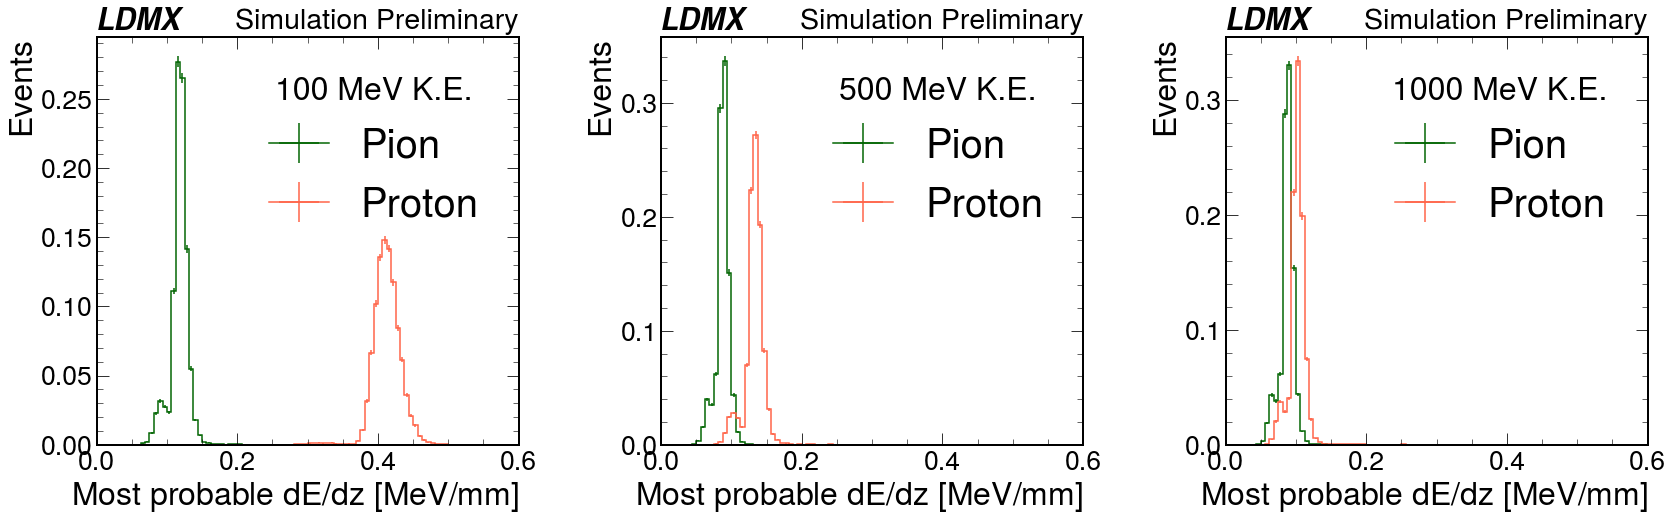

In [85]:
#oneDPlot(hists["recoil_dedz"],r"$dE/dz$ [MeV/mm]","Recoil Sim Hits")
#oneDPlot(hists["recoil_avgEdep"],r"Average Energy deposited [MeV]")
oneDPlot(hists["recoil_mostProbable"],r"Most probable $dE/dz$ [MeV/mm]","Events",figname="mostprob_dedz_recoil")
